<a href="https://colab.research.google.com/github/owenfab/IDS/blob/main/HW6/fabula_HW6_problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IDS HW 6
##Owen Fabula
##Problem 1: Python
###Part 1: Reading in and cleansing the data
Before I could write any of the functions, I needed to read in the dataset and perform data cleansing. I first imported relevant libraries and read the dataset into a dataframe.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mpl

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [ ]:
#creating dataframe from raw csv
#get url of raw csv from GitHub and load csv content into data frame
training = pd.read_csv("https://raw.githubusercontent.com/bforoura/IDS/main/HW4/adult_training.csv", sep=",")
training

,age,workclass,education,marital-status,occupation,sex,capital-gain,capital-loss,income
0,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Male,0,0,<=50K
1,38,Private,9,Divorced,Handlers-cleaners,Male,0,0,<=50K
2,49,Private,5,Married-spouse-absent,Other-service,Female,0,0,<=50K
3,52,Self-emp-not-inc,9,Married-civ-spouse,Exec-managerial,Male,0,0,>50K
4,31,Private,14,Never-married,Prof-specialty,Female,14084,0,>50K
...,...,...,...,...,...,...,...,...,...
14792,43,Self-emp-not-inc,10,Married-civ-spouse,Craft-repair,Male,0,0,<=50K
14793,32,Private,6,Married-civ-spouse,Handlers-cleaners,Male,0,0,<=50K
14794,32,Private,14,Never-married,Tech-support,Male,0,0,<=50K
14795,58,Private,9,Widowed,Adm-clerical,Female,0,0,<=50K


Since we have already worked with the adult_training dataset, I knew that the '?' character was being used as a placeholder for missing values and that 99999 was being used as a placeholder for missing values in the capital-gain column. As such, I searched through and replaced those values as I did in the problem1_python notebook. The below code does that:

In [ ]:
#change each ? (or 99999 for capital-gain) to np.NaN
row = 0 #row index
col = 0 #col index
for i in training.columns: #go through each column
  row = 0 #reset row counter each time
  for j in training[i]: #for each element in each column
    if (j == '?'): #check if '?'
      training.iloc[row,col] = np.NaN #make '?' np.NaN
    row = row + 1 #increment row index
  col = col + 1 #increment col index
#for capital-gain specifically
r = 0 #row index
for k in training['capital-gain']:
  if k == 99999: #placeholder value in capital-gain
    training.iloc[r,6] = np.NaN #change placeholder to np.NaN; 6 is hardcoded because capital-gain is col 6
  r = r + 1 #increment row index

#make sure any of this worked:
print("num NaN after replacement: ",training.isna().values.sum())

#now to impute: numeric columns -> mean; categorical columns -> mode
training['age'] = training['age'].fillna(training['age'].mean())
training['workclass'] = training['workclass'].fillna(training['workclass'].mode()[0])
training['education'] = training['education'].fillna(training['education'].mean())
training['marital-status'] = training['marital-status'].fillna(training['marital-status'].mode()[0])
training['occupation'] = training['occupation'].fillna(training['occupation'].mode()[0])
training['sex'] = training['sex'].fillna(training['sex'].mode()[0])
training['capital-gain'] = training['capital-gain'].fillna(training['capital-gain'].mean())
training['capital-loss'] = training['capital-loss'].fillna(training['capital-loss'].mean())
training['income'] = training['income'].fillna(training['income'].mode()[0])

#check to make sure imputation worked
print("num NaN after imputation: ",training.isna().values.sum())

num NaN after replacement:  1732
num NaN after imputation:  0


From the above output, I knew that I replaced the missing values correctly. Next, I wanted to check and see if there were any outliers in the dataset and if so, impute them with the mean. The following code does what was just described:

In [ ]:
#this function just returns an array of row positions of all outliers in a given column from a dataframe
def outlierPos(col):
  pos = []
  mean = col.mean()
  stdev = col.std()
  rowPos = 0
  for j in col:
    if ((j - mean) / stdev > 3 or (j - mean) / stdev < -3):
      pos.append(rowPos)
    rowPos = rowPos + 1
  return pos

#using the above, we can find all the outliers for the numeric attributes
#age
outliers = outlierPos(training['age']) #find positions of outliers
for k in outliers:
  training.iloc[k,0] = training.age.mean()
#education
outliers = outlierPos(training['education']) #find positions of outliers
for k in outliers:
  training.iloc[k,2] = training.education.mean()
#capital-gain
outliers = outlierPos(training['capital-gain']) #find positions of outliers
for k in outliers:
  training.iloc[k,6] = training['capital-gain'].mean()
#capital-loss
outliers = outlierPos(training['capital-loss']) #find positions of outliers
for k in outliers:
  training.iloc[k,7] = training['capital-loss'].mean()

With the above code complete, work may be done on the dataset.

###Part 2: Classification Model Functions

Before I could write the four functions required for the assignment, I needed to have usable data with which I could test the functions on. I decided to see what marital-status and occupation (predictors) could say about income (target), so I made a new dataframe with just those columns, another new dataframe with the encoded data (since all the original data was categoric), and then split the data into training and testing data.

In [ ]:
#filter out only the columns we want from the original data
smallDF = training.filter(['marital-status','occupation','income'], axis=1)

#new dataframe where the encoded data will go
encoded_MOI = pd.DataFrame()

le = preprocessing.LabelEncoder()

#encode the whole dataframe (all categoric)
for i in range(0, smallDF.shape[1]):
  encoded_MOI[smallDF.columns[i]] = le.fit_transform(smallDF[smallDF.columns[i]])

#break encoded dataset into predictors and target
x = encoded_MOI.filter(['marital-status','occupation'])
y = encoded_MOI['income']

#split train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, shuffle=True, train_size=0.80, stratify=y)

####makeDTModel function
To create the makeDTModel function, I used the following code:

In [ ]:
#makeDTModel - creates classification model using given training data
def makeDTModel(kind, xTrain, yTrain, leaf=5, depth=5):
  return DecisionTreeClassifier(criterion=kind,
                                max_leaf_nodes=leaf,
                                max_depth=depth,
                                random_state=120).fit(xTrain,yTrain)

The above code simply returns a model with the specified criteria (i.e., "gini" or "entropy") that has also been fitted to the given training data. Of course, one will have had to prepare their training data in advance. The user may also specify the max depth and leaf nodes with the function call.
####displayTree function
To make the displayTree function, I used the following code:

In [ ]:
#displayTree - displays graphic and text representation of DT model
def displayTree(model, predictor, target):
  #first, print the text tree
  print(tree.export_text(model, feature_names=predictor))
  #now the graphic tree
  tree.plot_tree(model,
                 feature_names=predictor,
                 class_names=predictor, filled=True)

The above function takes as its parameters three things: first, the classifier, then the original data labels, and finally the target value labels so the representations can display classes.
####displayCM function
To make the displayCM function, I used the following code:

In [ ]:
#displayCM - displays confusion matrix and heatmap for a particular model
def displayCM(model, xTrain, yTrain, xTest, yTest):
  #get predictions of model based on test data and then print
  modelpred = model.predict(xTest)
  modelcm = confusion_matrix(y_true=yTest, y_pred=modelpred)
  print(modelcm)
  #now display the heatmap
  mpl.figure(figsize=(8,8))
  sns.heatmap(modelcm, annot=True, linewidths=.5, square=True,
              cmap='Oranges_r', fmt='0.4g')
  mpl.xlabel("Actual")
  mpl.ylabel("Predicted")

The above function simply takes in the model and training and testing data as its inputs and displays the confusion matrix and heatmaps based on those inputs.
####compareModels function
To makes the compareModels function, I used the following code:

In [ ]:
#compareModels - plot the accuracy of two different models side-by-side
def compareModels(model1, training_score1, test_score1, model2, training_score2, test_score2, title="Model Accuracy", model_names=["Model 1", "Model 2"]):
  #get train and test scores for both models into arrays
  trainingScores = [training_score1, training_score2]
  testingScores = [test_score1, test_score2]
  x = np.arange(2)
  width = 0.35
  fig, ax = mpl.subplots()
  #create bars for the graph
  rects1 = ax.bar(x - width/2, trainingScores, width, label='Training', color='navy')
  rects2 = ax.bar(x + width/2, testingScores, width, label='Testing', color='orange')
  #labels and other graph configurations
  ax.set_ylabel('Model Accuracy')
  ax.set_xticks(x)
  ax.set_ylim(0,1)
  ax.set_xticklabels(model_names)
  ax.legend(bbox_to_anchor = (1.3, 1.0), loc='upper right')
  mpl.title(title)
  mpl.show()

The above code takes both models and their scores as parameters, and then displays the given information in side-by-side bar graphs.
####Testing the above
To test the above functions, I used the encoded data from before the function declarations. I decided to add extra default parameters so that the user could change the title of the graph and the x axis labels should they so desire.

|--- marital-status <= 2.50
|   |--- marital-status <= 0.50
|   |   |--- class: 0
|   |--- marital-status >  0.50
|   |   |--- capital-gains-losses <= 8.50
|   |   |   |--- class: 0
|   |   |--- capital-gains-losses >  8.50
|   |   |   |--- class: 1
|--- marital-status >  2.50
|   |--- capital-gains-losses <= 8.50
|   |   |--- class: 0
|   |--- capital-gains-losses >  8.50
|   |   |--- class: 0



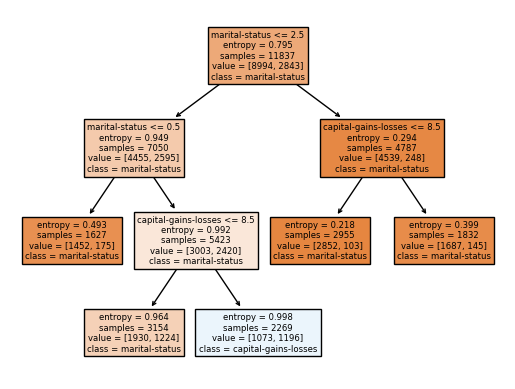

In [ ]:
#makeDTModel - one with gini and one with entropy
myDT = makeDTModel(kind="entropy", xTrain=x_train, yTrain=y_train, leaf=5, depth=3)
myOtherDT = makeDTModel(kind="gini", xTrain=x_train, yTrain=y_train, leaf=5, depth = 3)
#displayTree
xlabels = ['marital-status','capital-gains-losses']
ylabels = ['income']
displayTree(myDT, xlabels, ['<=50K','>50K'])

[[1981  268]
 [ 393  318]]


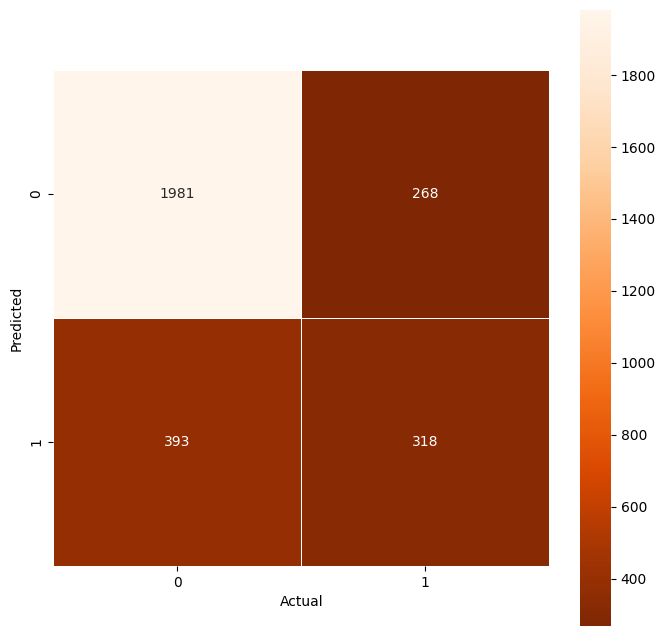

In [ ]:
#test displayCM
displayCM(myDT,x_train,y_train,x_test,y_test)

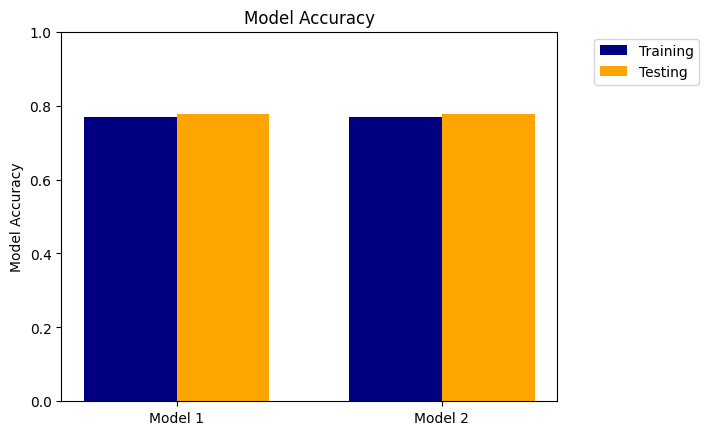

In [ ]:
#test compareModels - must score first
myDT_train_score = myDT.score(x_train, y_train)
myDT_test_score = myDT.score(x_test, y_test)
otherDT_train_score = myDT.score(x_train, y_train)
otherDT_test_score = myDT.score(x_test, y_test)
#now pass everything to compareModels
compareModels(myDT, myDT_train_score, myDT_test_score, myOtherDT, otherDT_train_score, otherDT_test_score)

The above outputs were as expected, so we can move on.
###Part 3: Effects of max_depth and max_leaf_nodes on DTs
To test the effect of max_depth and max_leaf_nodes on the accuracy of a decision tree, I decided to iterate through different sizes (e.g., 2, 3, 4, None) and plot the accuracy for each model's accuracy. Below is the code that does just that:

FOR ('max_depth =', 2, 'max_leaf_nodes=', 2) 
CART training score: 0.7598209005660218 
CART testing score: 0.7597972972972973 
C5.0 training score: 0.7598209005660218 
C5.0 testing score: 0.7597972972972973


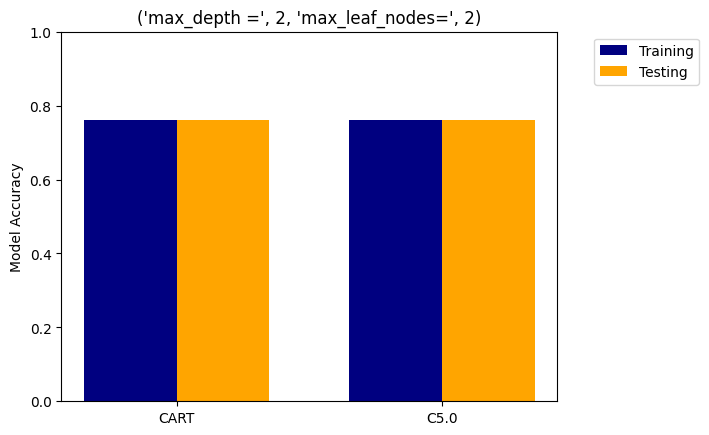



FOR ('max_depth =', 3, 'max_leaf_nodes=', 3) 
CART training score: 0.7598209005660218 
CART testing score: 0.7597972972972973 
C5.0 training score: 0.7598209005660218 
C5.0 testing score: 0.7597972972972973


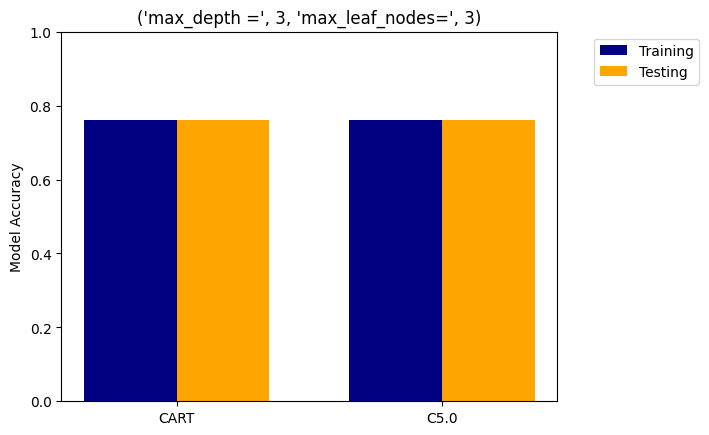



FOR ('max_depth =', 4, 'max_leaf_nodes=', 4) 
CART training score: 0.770212046971361 
CART testing score: 0.7766891891891892 
C5.0 training score: 0.770212046971361 
C5.0 testing score: 0.7766891891891892


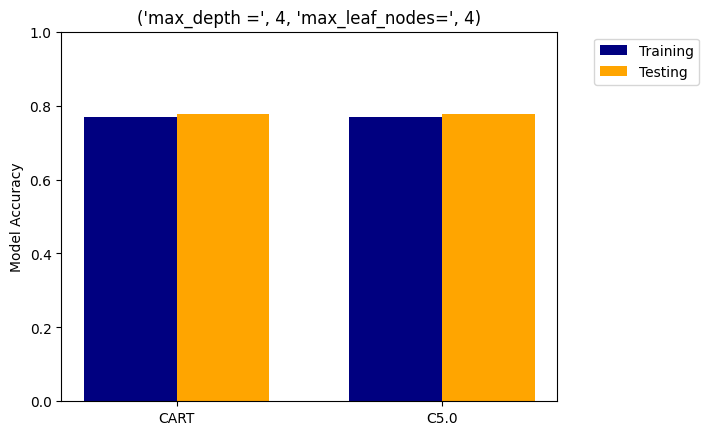



FOR ('max_depth =', 5, 'max_leaf_nodes=', 5) 
CART training score: 0.770212046971361 
CART testing score: 0.7766891891891892 
C5.0 training score: 0.770212046971361 
C5.0 testing score: 0.7766891891891892


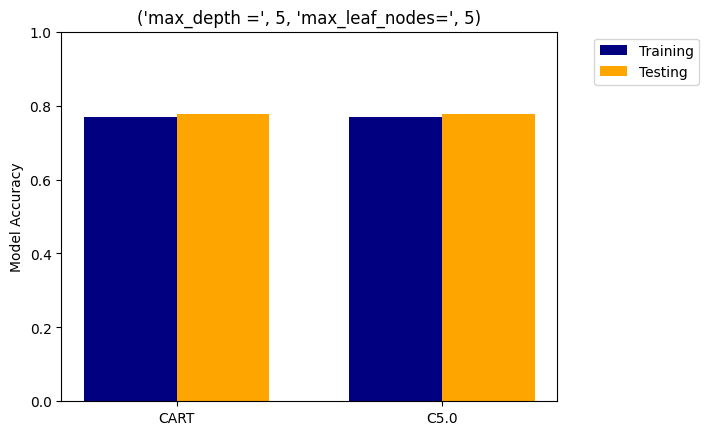



FOR ('max_depth =', None, 'max_leaf_nodes=', None) 
CART training score: 0.8115231899974655 
CART testing score: 0.8141891891891891 
C5.0 training score: 0.8115231899974655 
C5.0 testing score: 0.8141891891891891


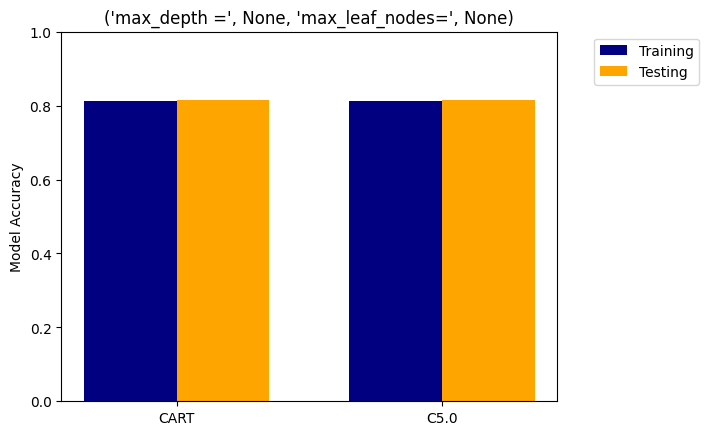

In [ ]:
#array of values for max_depth and max_leaf_nodes
values = [2, 3, 4, 5, None]
for i in values:
  #make models with leaf and depth set as the value at i (in arr values)\
  cartDT = makeDTModel(kind="gini",xTrain=x_train,yTrain=y_train,leaf=i,depth=i)
  cfiveDT = makeDTModel(kind="gini",xTrain=x_train,yTrain=y_train,leaf=i,depth=i)
  #now score the models
  cartDT_train_score = cartDT.score(x_train, y_train)
  cartDT_test_score = cartDT.score(x_test, y_test)
  cfiveDT_train_score = cfiveDT.score(x_train, y_train)
  cfiveDT_test_score = cfiveDT.score(x_test, y_test)
  #to change graph title
  graphTitle = "max_depth =",i,"max_leaf_nodes=",i
  print("FOR",graphTitle,"\nCART training score:",cartDT_train_score,
        "\nCART testing score:",cartDT_test_score,
        "\nC5.0 training score:",cfiveDT_train_score,
        "\nC5.0 testing score:",cfiveDT_test_score)
  #now call compareModels
  compareModels(model1=cartDT, training_score1=cartDT_train_score,
                test_score1=cartDT_test_score,
                model2=cfiveDT, training_score2=cfiveDT_train_score,
                test_score2=cfiveDT_test_score,
                title=graphTitle, model_names=['CART','C5.0'])
  print("\n")

##Summary of the above
From the above output, we can glean some information:<ul><li>Changing the maximum amount of leaf nodes and tree depth does indeed affect the accuracy of a decision tree classifier:</li><ul><li>Specifically, the greater the value for max_depth and max_leaf_nodes, the more accurate the decision tree classifier becomes. This is evident from the above data: when the classifiers were only given 5 depth and 2 leaf nodes for a maxiumum, their accuracy for both training and testing data were approximately 0.759; however, when the classifiers were given None as their maximum depth and leaf nodes (i.e., given no limit), their accuracy for both training and testing data were approximately 0.81: they improved.</li></ul><li>Additionally, it is clear that there is not a noticible difference between CART classifiers and C5.0 classifiers concerning accuracy and max depth and leaf nodes.<ul><li>In particular, both kinds of models had approximately the same accuracy for both training and testing data for all values for max_depth and max_leaf_nodes.</li></ul></li></ul>